In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive/SAM

/content/drive/My Drive/SAM


In [ ]:
!pip install git+https://github.com/bowang-lab/MedSAM.git

In [ ]:
# %matplotlib widget
from segment_anything import sam_model_registry
from demo_next import BboxPromptDemo_next
from google.colab import output
output.enable_custom_widget_manager()
MedSAM_CKPT_PATH = "sam_vit_b_01ec64.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

In [ ]:
%matplotlib widget

import glob

image_files = glob.glob('test/*.png')
bbox_prompt_demo = BboxPromptDemo_next(medsam_model)
bbox_prompt_demo.show(image_files)

In [ ]:
# %matplotlib widget
from segment_anything import sam_model_registry
from demo_next import BboxPromptDemo_next
from google.colab import output
output.enable_custom_widget_manager()
MedSAM_CKPT_PATH = "sam_vit_b_01ec64.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import gc
import json
# JSON 파일 불러오기
with open('lung_seg.json', 'r') as f:
    data = json.load(f)

In [ ]:
import glob

pathes = glob.glob('lung_deeplab/images/*.png')

In [ ]:
# import os
# imgs = [file for file in os.listdir('rectum_imgs') if file != '.ipynb_checkpoints']
# imgs.sort(key=lambda x: int(x.split('.')[0]))
# len(imgs)

28

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [ ]:
from skimage import io, transform
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


for i in tqdm.tqdm(range(len(pathes))):
    img_array = cv2.imread(data[i]['path'])
    bbox_info = data[i]['bbox']
    bbox = [bbox_info['x'],bbox_info['y'],bbox_info['x']+bbox_info['w'],bbox_info['y']+bbox_info['h']]
    H, W, _ = img_array.shape

    # preprocessing
    img_1024 = transform.resize(
        img_array, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )

    box_np = np.array([bbox])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    io.imsave(
        join('rectum_mask', f"seg_{i}.png"),
        medsam_seg,
        check_contrast=False,
    )
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_array)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_array)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("SAM Segmentation")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from skimage import io, transform
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


for i in tqdm.tqdm(range(len(imgs))):
    img_array = cv2.imread(data[i]['path'])
    bbox_info = data[i]['bbox']
    bbox = [bbox_info['x'],bbox_info['y'],bbox_info['x']+bbox_info['w'],bbox_info['y']+bbox_info['h']]
    H, W, _ = img_array.shape

    # preprocessing
    img_1024 = transform.resize(
        img_array, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )

    box_np = np.array([bbox])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    io.imsave(
        join('brain_mask', f"seg_{i}.png"),
        medsam_seg,
        check_contrast=False,
    )
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_array)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_array)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("SAM Segmentation")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from skimage import io, transform
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


for i in tqdm.tqdm(range(len(imgs))):
    img_array = cv2.imread(data[i]['path'])
    bbox_info = data[i]['bbox']
    bbox = [bbox_info['x'],bbox_info['y'],bbox_info['x']+bbox_info['w'],bbox_info['y']+bbox_info['h']]
    H, W, _ = img_array.shape

    # preprocessing
    img_1024 = transform.resize(
        img_array, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )

    box_np = np.array([bbox])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    io.imsave(
        join('auto_mask_5', f"seg_{i}.png"),
        medsam_seg,
        check_contrast=False,
    )
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_array)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_array)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("SAM Segmentation")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import gc
import json
# JSON 파일 불러오기
with open('json_data_morp5_ex10.json', 'r') as f:
    data = json.load(f)

In [ ]:
from skimage import io, transform
import numpy as np
import tqdm
import cv2
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


for i in tqdm.tqdm(range(len(imgs))):
    img_array = cv2.imread(data[i]['path'])
    bbox_info = data[i]['bbox']
    bbox = [bbox_info['x'],bbox_info['y'],bbox_info['x']+bbox_info['w'],bbox_info['y']+bbox_info['h']]
    H, W, _ = img_array.shape

    # preprocessing
    img_1024 = transform.resize(
        img_array, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )

    box_np = np.array([bbox])
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    io.imsave(
        join('auto_mask_5_ex10', f"seg_{i}.png"),
        medsam_seg,
        check_contrast=False,
    )
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_array)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_array)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("SAM Segmentation")
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2

img_array = cv2.imread(data[1]['path'])
img_array.shape

(256, 256, 3)

(512, 512, 3)


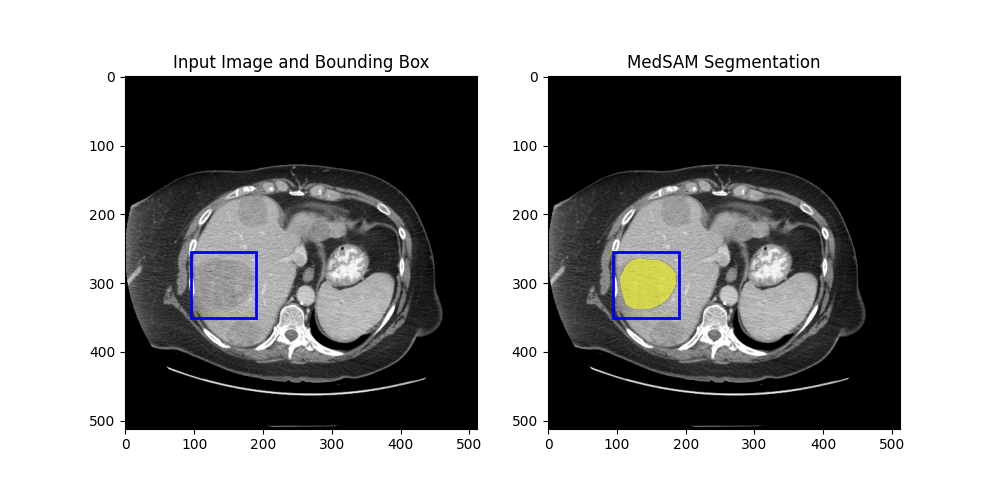

In [ ]:
# -*- coding: utf-8 -*-
# %% load environment
import numpy as np
import matplotlib.pyplot as plt
import os

join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import argparse


# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


# %% load model and image
parser = argparse.ArgumentParser(
    description="run inference on testing set based on MedSAM"
)
parser.add_argument(
    "-i",
    "--data_path",
    type=str,
    default="img_demo.png",
    help="path to the data folder",
)
parser.add_argument(
    "-o",
    "--seg_path",
    type=str,
    default="",
    help="path to the segmentation folder",
)
parser.add_argument(
    "--box",
    type=list,
    default=[95, 255, 190, 350],
    help="bounding box of the segmentation target",
)
parser.add_argument("--device", type=str, default="cuda:0", help="device")
parser.add_argument(
    "-chk",
    "--checkpoint",
    type=str,
    default="medsam_vit_b.pth",
    help="path to the trained model",
)
args = parser.parse_args(args=[])

device = args.device
medsam_model = sam_model_registry["vit_b"](checkpoint=args.checkpoint)
medsam_model = medsam_model.to(device)
medsam_model.eval()

img_np = io.imread(args.data_path)
if len(img_np.shape) == 2:
    img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
else:
    img_3c = img_np
print(img_3c.shape)
H, W, _ = img_3c.shape
# %% image preprocessing
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = (
    torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
)

box_np = np.array([args.box])
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
# io.imsave(
#     join(args.seg_path, "seg_" + os.path.basename(args.data_path)),
#     medsam_seg,
#     check_contrast=False,
# )

# %% visualize results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()

In [ ]:
medsam_model.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [ ]:
!pip install tqdm

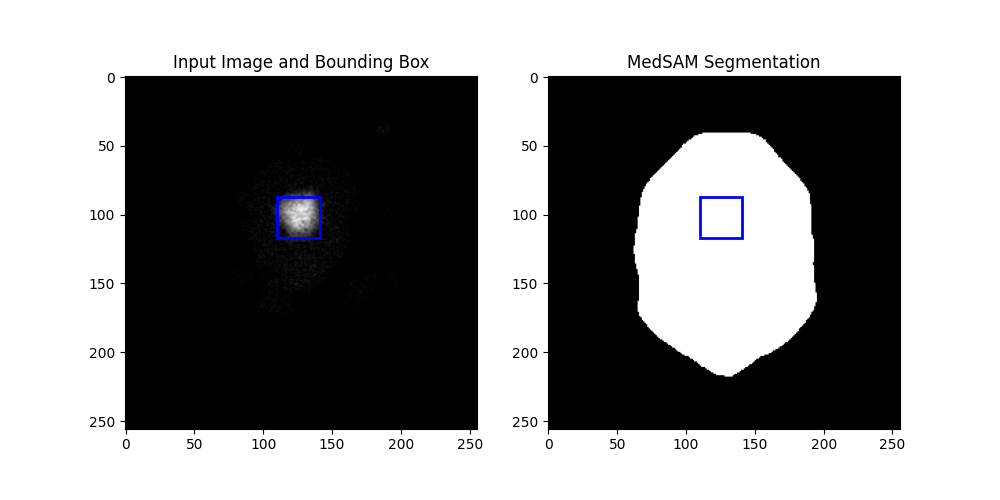

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = Image.open('seg_mask/seg_0.png')
img = np.array(img)
plt.imshow(img,'gray')
plt.show()